# Classification with BNN 
Probabilistic Programming Project 2, Olteanu Fabian Cristian, FMI, AI Master, Year 1

In [1]:
using FillArrays
using Flux
using Gen
using Plots
using ReverseDiff

using DataFrames
using LinearAlgebra
using Random
using StatsPlots, SyntheticDatasets
using MLJ
using Distributions

## Gaussian Quantiles Dataset (binary classification case)
I will start by generating a relatively small gaussian quantiles set with 2 classes and 2 features. Later on I will construct and train a bayesian neural network with Flux and Gen and a traditional neural network and compare the accuracy results between the two models.  

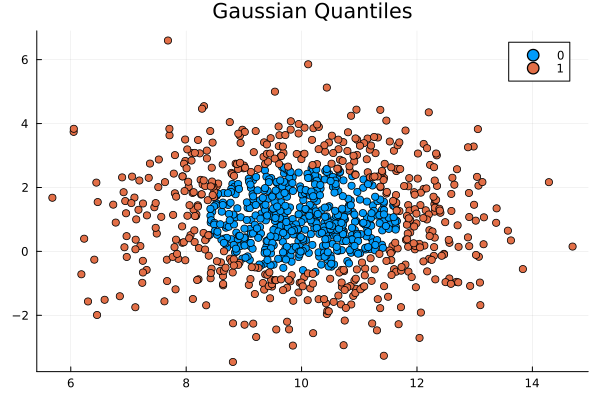

In [42]:
gauss = SyntheticDatasets.make_gaussian_quantiles( 
    mean = [10,1], 
    cov = 2.0,
    n_samples = 1000, 
    n_features = 2,
    n_classes = 2, 
    shuffle = true,
    random_state = 1
)

@df gauss scatter(:feature_1, :feature_2, group = :label, title = "Gaussian Quantiles")


Data preprocessing

In [43]:
data, labels = unpack(gauss, !=(:label), ==(:label))
data = convert(Matrix, data)
train_idx, test_idx = partition(1:length(labels), 0.8, rng = 123)

n_train = length(train_idx)
n_test = length(test_idx)

train_data = transpose(data[train_idx,:])
train_labels = labels[train_idx]
test_data = transpose(data[test_idx,:])
test_labels = labels[test_idx]

200-element Vector{Int32}:
 1
 0
 1
 1
 0
 1
 0
 1
 1
 0
 ⋮
 1
 1
 0
 0
 1
 1
 0
 0
 0

Constructing the neural network with the following architecture:

![network](https://user-images.githubusercontent.com/422990/47970321-bd172080-e038-11e8-9c6d-6c2bd790bd8a.png)

In [44]:
# Construct a neural network using Flux
nn_classic = Chain(Dense(2, 3, tanh), Dense(3, 2, tanh), Dense(2, 1, σ))

# Extract weights and a helper function to reconstruct NN from weights
parameters_initial, reconstruct = Flux.destructure(nn_classic)

n_params = length(parameters_initial) # number of paraemters in NN

20

### Constructing the Gen model (BNN)

In [45]:
@gen function bayes_nn(xs, ts, nparameters, reconstruct, alpha = 0.09)
    parameters ~ mvnormal(Zeros(nparameters), Matrix(I, nparameters, nparameters) / alpha)

    # Construct NN from parameters
    nn = reconstruct(parameters)
    # Forward NN to make predictions
    preds = nn(xs)

    obs = Bool[]
    # Observe each prediction.
    for i in 1:length(ts)
        push!(obs, {(:obs, i)} ~ bernoulli(preds[i]))
    end
    
    obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, Some(0.09)], var"##bayes_nn#422", Bool[0, 0, 0, 0, 0], false)

In [46]:
function make_constraints(labels)
    constraints = Gen.choicemap()
    for i=1:n_train
        constraints[(:obs, i)] = labels[i]
    end
    constraints
end

make_constraints (generic function with 1 method)

Constructing $\theta$ (of dimension $n_{iter}$ x $n_{params}$), composed of vectors representing the inferred parameters (weights and biases) of our neural network (the rows of the matrix).

In [47]:
observations = make_constraints(train_labels)

function do_inference(amount_of_computation, iter, model_params)
    
    (trace, _) = Gen.importance_resampling(bayes_nn, model_params, observations, amount_of_computation);
    return trace

end;

n_iter = 100
trs = [do_inference(10000, i, (train_data, train_labels, n_params, reconstruct, )) for i = 1:n_iter]
theta = [trs[i][:parameters] for i=1:n_iter]
theta = permutedims(hcat(theta...)) #convert to n_iter x n_params matrix


100×20 Matrix{Float64}:
 -1.0285     5.60766    1.97158   …  -1.8811    -2.37827    -0.758243
 -1.42957    3.77238   -0.230789      4.47711    0.456482    3.90353
 -0.908781   2.94295   -0.212495      3.4076     3.17572     6.34072
  0.180151  -1.40309    0.789064     -3.62947    1.56714     2.01718
  0.111574   1.81467    1.01583      -0.830296   2.75363     1.0127
 -0.983784  -0.558875  -1.24095   …   0.62375   -2.1231      2.022
  2.42606   -0.305345  -4.29294       0.364443   1.67526     0.814098
 -0.679438   0.53818    0.180004     -0.659937  -1.30162     1.40464
 -0.472406   3.36166   -0.310988      2.67739    1.2296      3.24064
 -0.515073  -0.332358   0.882491     -3.12207    1.0934      1.1139
  ⋮                               ⋱                         
 -1.61948   -2.11229   -0.448656     -3.55087   -2.3682      3.77494
 -0.142726  -1.49985    1.44563       3.19802   -2.83496     0.655832
  0.860134   1.24779   -1.40149      -4.413     -3.39308     7.38897
 -0.351097   2.6709

The train and test accuracies are calculated as the maximum of the accuracies based on the predictions of the model used with every row of parameters from the trace array.

In [48]:
means_train = []
means_test = []
for idx=1:n_iter
    nn_new = reconstruct(theta[idx,:])
    preds_train = nn_new(train_data)
    preds_train = [x < 0.5 for x in preds_train]
    means_train = vcat(means_train, mean([preds_train[i] == train_labels[i] for i = 1:n_train]))
    preds_test = nn_new(test_data)
    preds_test = [x < 0.5 for x in preds_test]
    means_test = vcat(means_test, mean([preds_test[i] == test_labels[i] for i = 1:n_test]))
end
println("Train accuracy: ", maximum(means_train))
println("Test accuracy: ", maximum(means_test))

Train accuracy: 0.5025
Test accuracy: 0.49


Parameter histograms

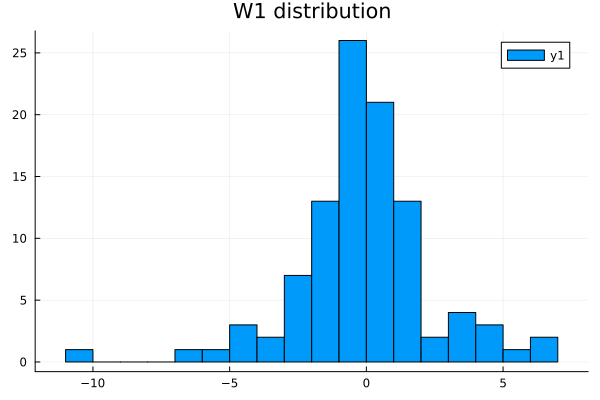

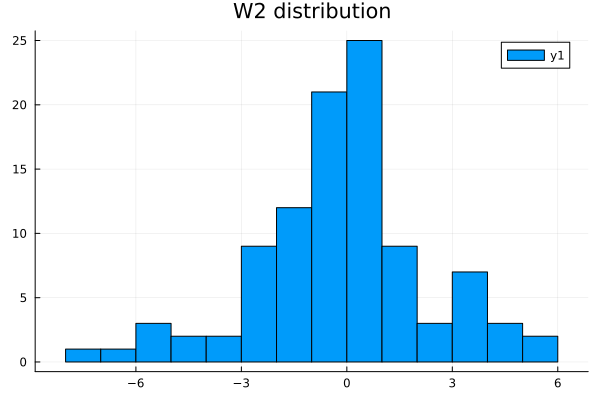

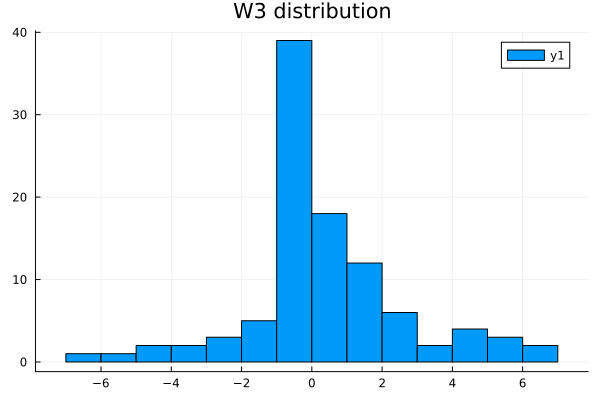

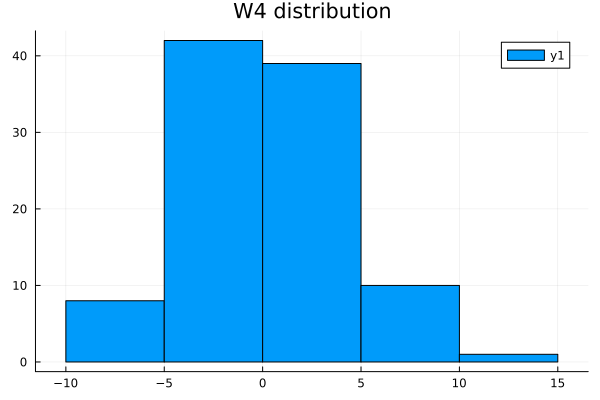

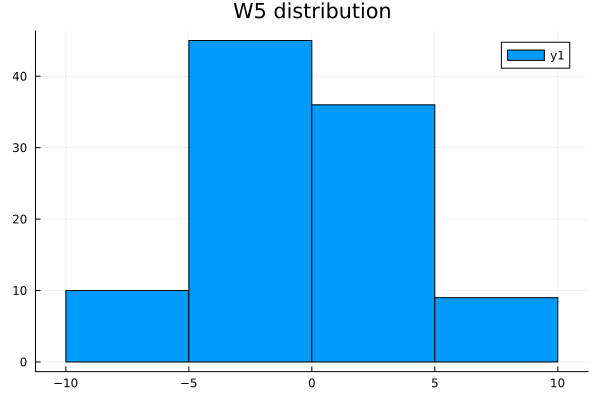

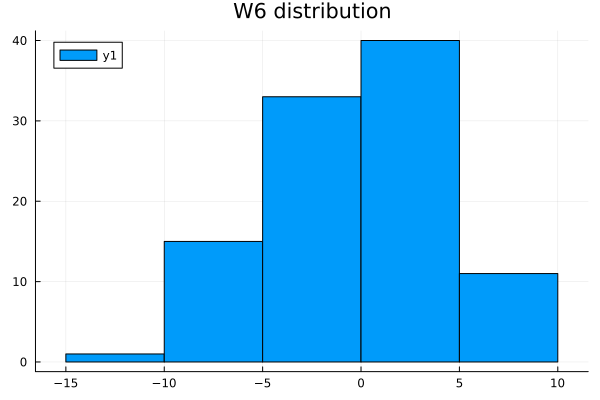

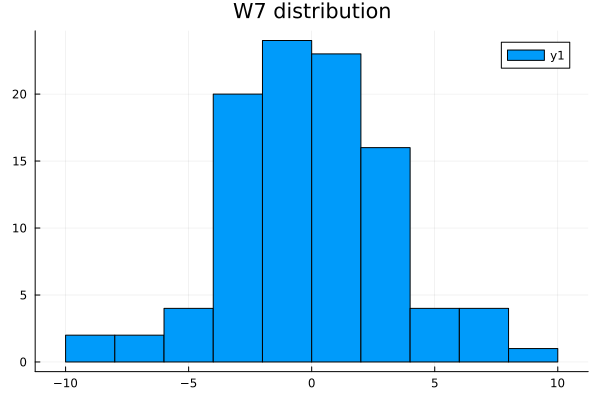

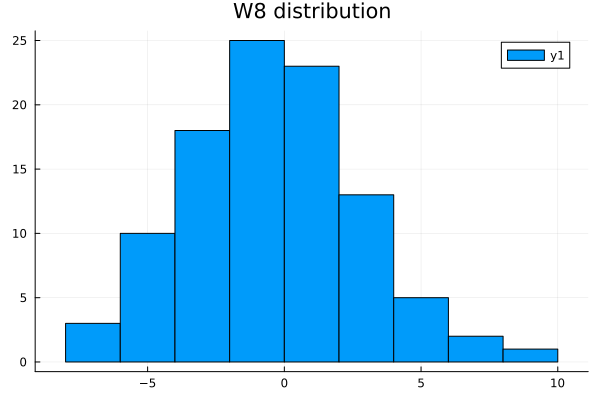

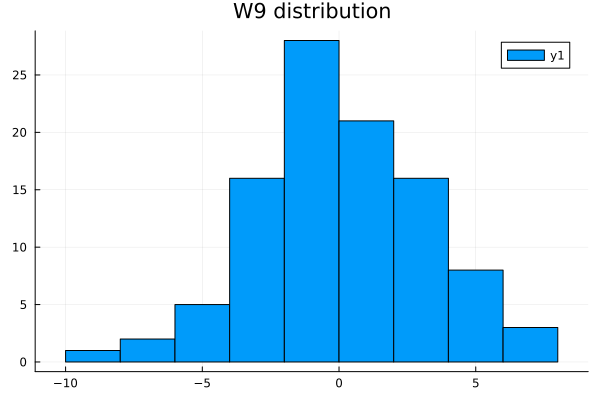

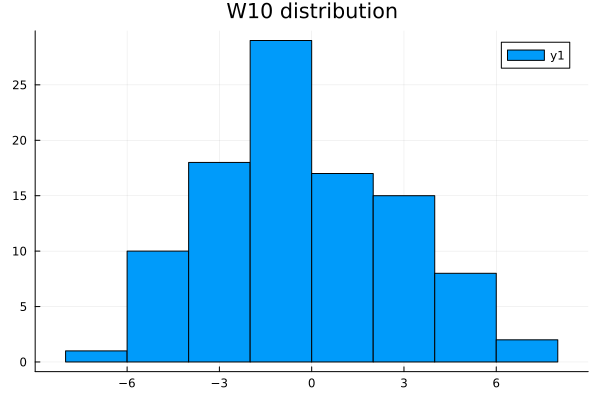

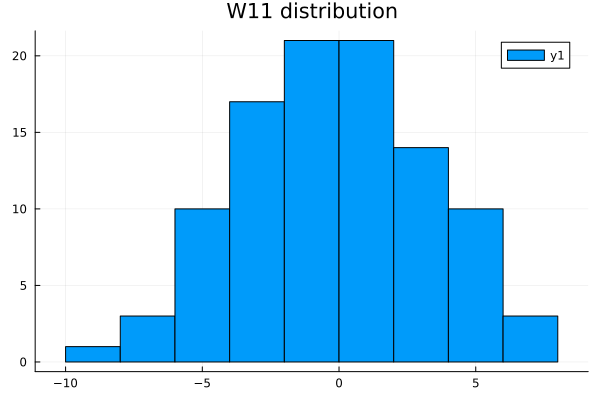

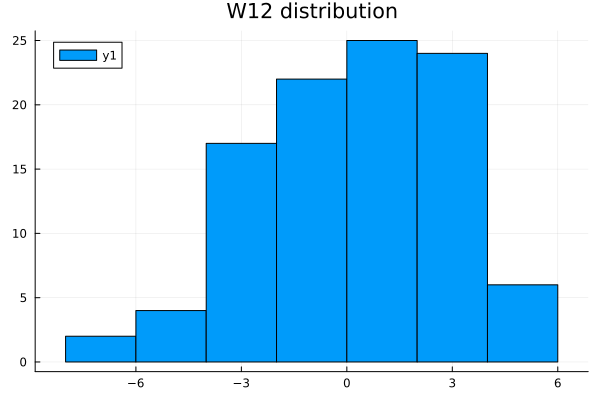

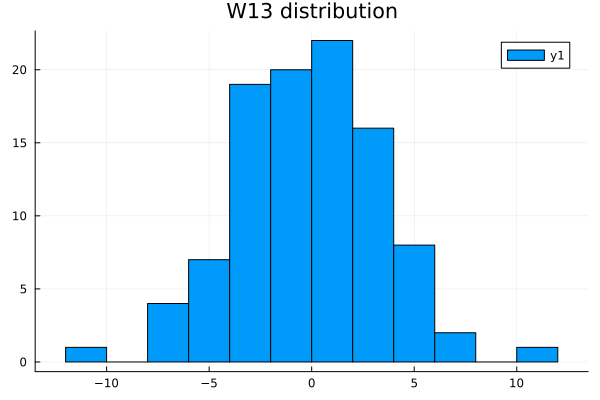

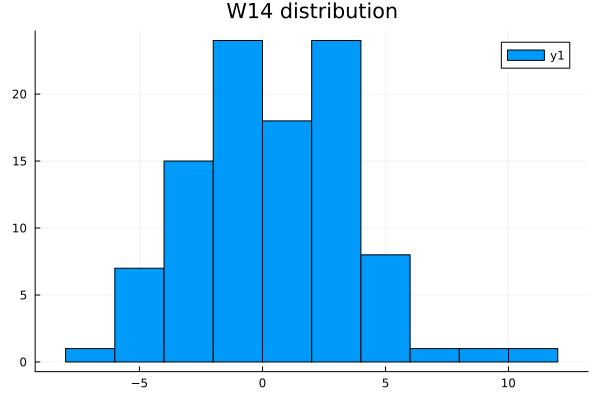

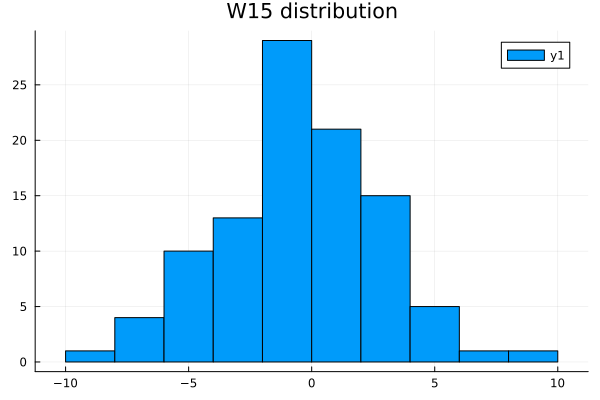

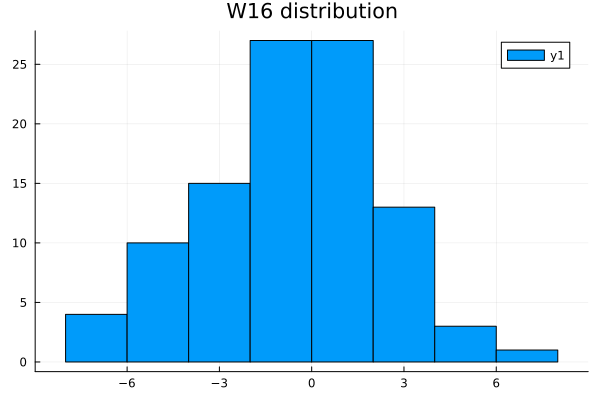

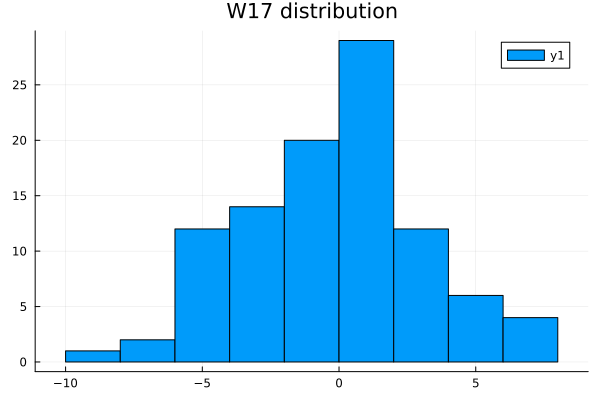

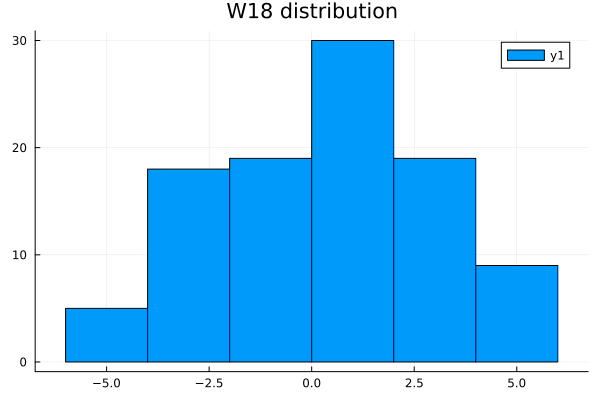

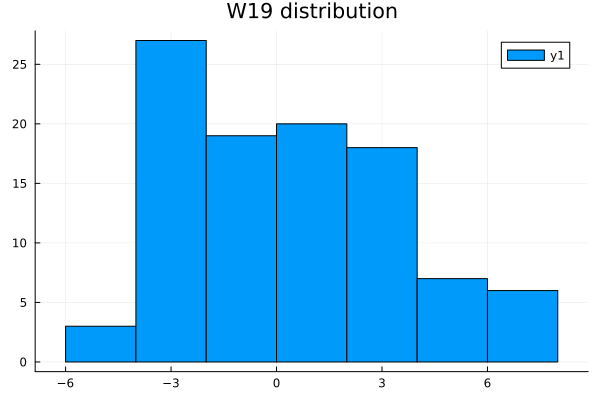

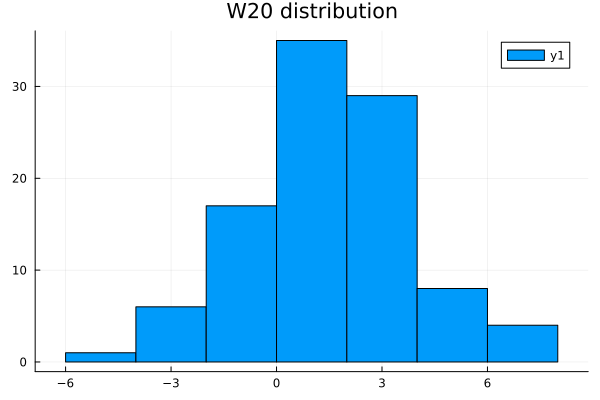

In [49]:
for i in 1:n_params
  display(histogram(theta[:,i], title = "W$i distribution"))
end

### Constructing and training the traditional neural network
For this I will be using the keras library from Python, so the code will be in the second attached notebook.

In [59]:
# exporting dataset to a csv file to import in python; uncomment the code written below to generate the csv files
# using DelimitedFiles
# writedlm("dataset_binary.csv", Iterators.flatten(([names(gauss)], eachrow(gauss))), ',')
# writedlm("train_idx_binary.csv", train_idx)
# writedlm("test_idx_binary.csv", test_idx)

### Conclusion
Using the same train and test splits for training the BNN and NN (frequentist case) resulted in the following accuracies:
<table style="float: left; text-align: center;">
  <tr>
    <td colspan="2">BNN</td>
  </tr>
  <tr>
    <td>Train accuracy</td>
    <td>Test accuracy</td>
  </tr>
  <tr>
    <td>0.5025</td>
    <td>0.49</td>
  </tr>
</table>

<table style="text-align: center;">
  <tr>
    <td colspan="2">NN (frequentist)</td>
  </tr>
  <tr>
    <td>Train accuracy</td>
    <td>Test accuracy</td>
  </tr>
  <tr>
    <td>0.6480</td>
    <td>0.6</td>
  </tr>
</table>

In conclusion, for this particular dataset, the frequentist approach resulted in better accuracies. To note are the relatively low accuracy scores for both models, which could point to several points to improve, like tinkering with the neural net architecture, generating more points etc. 

## Gaussian Quantiles Dataset (multiclass classification case)

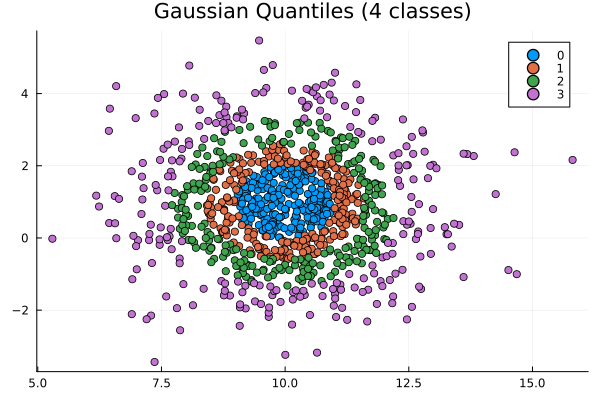

In [2]:
gauss = SyntheticDatasets.make_gaussian_quantiles(  
    mean = [10,1], 
    cov = 2.0,
    n_samples = 1000, 
    n_features = 2,
    n_classes = 4, 
    shuffle = true,
    random_state = 2
)

@df gauss scatter(:feature_1, :feature_2, group = :label, title = "Gaussian Quantiles (4 classes)")

In [3]:
data, labels = unpack(gauss, !=(:label), ==(:label))
data = convert(Matrix, data)
train_idx, test_idx = partition(1:length(labels), 0.8, rng = 123)

n_train = length(train_idx)
n_test = length(test_idx)

train_data = transpose(data[train_idx,:])
train_labels_0 = labels[train_idx]
train_labels = zeros((n_train, 4)) #casting to probability matrix
for i=1:n_train
    for j=1:4
        train_labels[i,j] = j-1 == train_labels_0[i]
    end
end

test_data = transpose(data[test_idx,:])
test_labels_0 = labels[test_idx]
test_labels = zeros((n_test, 4))
for i=1:n_test
    for j=1:4
        test_labels[i,j] = j-1 == test_labels_0[i]
    end
end

In [ ]:
# uncomment the code written below to generate csv files for the dataset

# using DelimitedFiles
# writedlm("dataset_multi.csv", Iterators.flatten(([names(gauss)], eachrow(gauss))), ',')
# writedlm("train_idx_multi.csv", train_idx)
# writedlm("test_idx_multi.csv", test_idx)

Constructing the NN for the multiclass problem. In this case, the architecture used was the following:
- input layer: size 2,
- first hidden layer: size 16, relu activation,
- second hidden layer: size 12, relu activation,
- third hidden layer: size 6, relu activation,
- output layer: size 4, softmax activation.

In [4]:
nn_init = Chain(
    Dense(2, 16, relu), 
    Dense(16, 12, relu), 
    Dense(12, 6, relu), 
    Dense(6, 4, relu), 
    softmax
)

parameters_initial, reconstruct = Flux.destructure(nn_init)

n_params = length(parameters_initial)

358

In [5]:
@gen function bayes_nn_multiclass(xs, ts, nparameters, reconstruct, alpha = 0.09)
    parameters ~ mvnormal(Zeros(nparameters), Matrix(I, nparameters, nparameters) / alpha)

    nn = reconstruct(parameters)
    preds = nn(xs)

    obs = Bool[]
    for i in 1:length(ts)
        push!(obs, {(:obs, i)} ~ bernoulli(preds[i]))
    end
    
    obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, Some(0.09)], var"##bayes_nn_multiclass#326", Bool[0, 0, 0, 0, 0], false)

In [6]:
function make_constraints(labels)
    constraints = Gen.choicemap()
    for i=1:n_train
        constraints[(:obs, i)] = labels[i]
    end
    constraints
end

make_constraints (generic function with 1 method)

In [7]:
observations = make_constraints(train_labels)

function do_inference(amount_of_computation, iter, model_params)
    
    (trace, _) = Gen.importance_resampling(bayes_nn_multiclass, model_params, observations, amount_of_computation);
    return trace

end

n_iter = 100
trs = [do_inference(10000, i, (train_data, train_labels, n_params, reconstruct, )) for i = 1:n_iter]
theta = [trs[i][:parameters] for i=1:n_iter]
theta = permutedims(hcat(theta...)) #convert to n_iter x n_params matrix

100×358 Matrix{Float64}:
  1.03056   -1.05395   -0.88712   …  -3.36998    -5.08279    -3.85916
 -1.04581   -3.41852    1.71294      -2.96057     1.15229    -0.765137
  1.55306   -0.412066   1.60116       3.6203      5.5038      4.73351
 -0.013424  -1.71702    2.98892       3.56956     5.68762     7.41676
  1.4176     2.03632    3.39194       4.1228      0.646866   -0.423517
  2.09612    3.26389    1.07313   …   2.10822    -3.65053    -1.15684
 -4.5163     0.886443   0.182195      5.70791    -0.0405971   4.87316
  6.78913    0.364369  -2.25331       0.0217301   1.83403    -1.62293
 -0.743083  -1.55913    1.88215       0.116456   -2.10076    -5.59301
 -6.25327    4.60639   -7.28339       3.28574    -2.24175    -5.81249
  ⋮                               ⋱   ⋮                      
 -1.80389   -0.734696   0.150404     -2.75084    -3.97244    -3.62695
 -8.46337   -0.839867   2.96403      -3.59669     1.81865    -1.47383
 -1.62576    0.279963   0.613992      0.921082    0.0800706  -5.04806
 

In [57]:
nn_new_multiclass = reconstruct(theta[100,:])
train_pred = nn_new_multiclass(train_data)

4×800 Matrix{Float64}:
 0.25  0.25  0.25  0.25  0.25  0.25  …  0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25

### Conclusion
The bayesian neural network did not seem to learn after training, the training predictions being equal probabilities of 25% for all training data. Thus, the analysis in the case of this dataset is inconclusive.

<table style="float: left; text-align: center;">
  <tr>
    <td colspan="2">BNN</td>
  </tr>
  <tr>
    <td>Train accuracy</td>
    <td>Test accuracy</td>
  </tr>
  <tr>
    <td>-</td>
    <td>-</td>
  </tr>
</table>
<table style="text-align: center;">
  <tr>
    <td colspan="2">NN (frequentist)</td>
  </tr>
  <tr>
    <td>Train accuracy</td>
    <td>Test accuracy</td>
  </tr>
  <tr>
    <td>0.5507</td>
    <td>0.5400</td>
  </tr>
</table>